In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *
import os

In [2]:
##general settings
LSST      = False
#if not LSST redhsift kernel
z0        = 1.
sigma_z   = 0.4
bin_num   = 'all'
bias      = 'simple'
z_source  = z_cmb
zmax      = z_source
chimax    = chi_z(zmax)
s         = 0.6
print('zmax=%d'%zmax, 'chimax=%d'%chimax)
chi_source = chi_z(z_source)

if LSST:
    if chi_source==chi_cmb:
        file_ext = 'lsst%s_cmblens'%str(bin_num)
    else:
        file_ext = 'lsst%s_deltalens_z%d'%(str(bin_num),z_source*10)

else:
    if chi_source==chi_cmb:
        file_ext = 'gaussgal_z%d_sigma%d_cmblens'%(z0*10,sigma_z*10)
    else:
        file_ext = 'gaussgal_z%d_sigma%d_deltalens_z%d'%(z0*10,sigma_z*10,z_source*10) 
    
file_ext+=bias+'_bias'

file_ext+=  '_zmax%d'%(zmax*10)
file_ext2 = 'zmax%d'%(zmax*10)
    
print(file_ext, file_ext2)


if bias == 'simple':
    bias_func = simple_bias
elif bias =='constant':
    bias_func = constant_bias
else:
    print('no valid bias function selected')



params = {}
params['LSST'] = LSST
params['z0'] = z0
params['sigma_z'] = sigma_z
params['bin_num'] = bin_num
params['chimax'] = chimax
params['chisource'] = chi_source
params['zsource'] = z_source
params['ext'] = file_ext
params['ext2']= file_ext2
params['s'] = s
params['bias']=bias

try: 
    params_ = pickle.load(open('../settings/params_%s.pkl'%file_ext,'rb'))
    assert(params==params_)
except:
    pass
    #pickle.dump(params,open('../settings/params_%s.pkl'%file_ext,'wb'))



zmax=1088 chimax=9414
gaussgal_z10_sigma4_cmblenssimple_bias_zmax10886 zmax10886


In [3]:
plotpath = '../plots/%s/'%file_ext
if os.path.isdir(plotpath):
    print('plot path exists')
else:
    os.mkdir(plotpath)

plot path exists


In [4]:
print('delta lensing with chimax %d'%chimax)
def lensing_kernel(xi):
    xmax = chi_source
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
    
if LSST:
    if bin_num == 'all':
        def galax_kernel(x):
            return lsst_kernel_cb(x)*simple_bias(x)
    else:
        def galax_kernel(x):
            return lsst_kernel_cbn[bin_num](x)*simple_bias(x)
else:
    kernel = gal_clus(Gauss_redshift(sigma_z=sigma_z,z0=z0), bias_func)
    def galax_kernel(x):
        return kernel(x)
    
print(galax_kernel(chimax))

delta lensing with chimax 9414
0.0


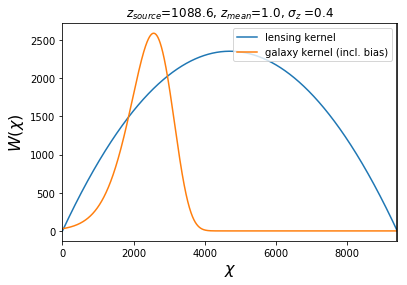

In [60]:
#see if kernels are sensible
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=12)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=12)   
chis = np.linspace(1,chimax,20000)
plt.plot(chis, lensing_kernel(chis)*chis**2,label='lensing kernel')
plt.plot(chis, galax_kernel(chis)*2e6, label='galaxy kernel (incl. bias)')
plt.axvline(x=chimax,color='black')
plt.xlabel('$\chi$',fontsize=16)
plt.ylabel('$W(\chi)$',fontsize=16)
plt.legend(loc='upper right')
plt.xlim(0,chimax)
plt.savefig(plotpath+'redshiftkernels_%s.png'%file_ext, bbox_inches='tight')

In [6]:
#only integrates to one for constant bias!
np.trapz(chis,galax_kernel(chis))

-1.9945955358611105

In [7]:
L = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)

### computing auto and cross spectra first

In [8]:
# clkg
try:
    ell_,Cl_kg= np.load('../output/cls/Clkg_%s.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    # chimax and kernels

    kernel1  = lensing_kernel
    kernel2  = galax_kernel

    n = 2

    begin=time.time()

    chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
    chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I2_ltrc[ii])


    Cl_pg = chimax * result*1./np.pi**2/2.*prefac/4.*2

    print('Time taken = ', time.time()-begin)

    Cl_kg = 1./2*(ell_*(ell_+1.))*Cl_pg

    np.save('../output/cls/Clkg_%s.npy'%(file_ext),[ell_,Cl_kg])

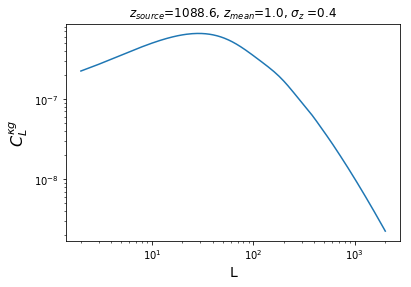

In [9]:
plt.figure()
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=12)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=12)    
plt.ylabel(r'$C_L^{\kappa g}$', fontsize=16)
plt.xlabel('L', fontsize=14)
p=plt.loglog(ell_,Cl_kg)
plt.loglog(ell_,-Cl_kg,c=p[0].get_color(),ls='--')
plt.savefig(plotpath+'clkg_%s.pdf'%file_ext, bbox_inches='tight')
plt.show()

In [10]:
#clkk
try:
    ell_,Cl_kk=np.load('../output/cls/Clkk_%s.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    # inflate by one dimensions (nu_n)
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    n=0

    begin=time.time()

    chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-nu_n_.reshape(1, 1, -1))

    chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1+z_chi(r2d*t2d*chimax)))
    chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d*1./t2d*chimax)*(1+z_chi(r2d/t2d*chimax)))
    chi2fac01 = chi2fac01 * t2d**(n+nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii])

    Clpp  = 2**2*chimax * result*1./np.pi**2/2.*prefac**2/4. #factor 2 for every phi = -2 int W psi
    #factor of 1/2 for every gaussian quadrature

    Cl_kk = 1./4*(ell_*(ell_+1.))**2*Clpp

    np.save('../output/cls/Clkk_%s.npy'%(file_ext),[ell_,Cl_kk])

    print('Time taken = ', time.time()-begin)

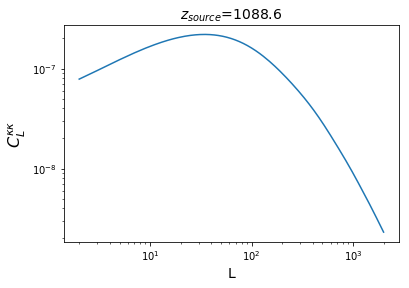

In [11]:
plt.figure()
plt.title('$z_{source}$=%.1f'%(z_source),fontsize=14)
plt.ylabel(r'$C_L^{\kappa \kappa}$', fontsize=16)
plt.xlabel('L', fontsize=14)
p=plt.loglog(ell_,Cl_kk)
plt.loglog(ell_,-Cl_kk,c=p[0].get_color(),ls='--')
plt.savefig(plotpath+'clkk_%s.pdf'%file_ext, bbox_inches='tight')
plt.show()

In [14]:
#clgg
try:
    ell_,Cl_gg = np.load('../output/cls/Clgg_%s.npy'%(file_ext))
except:    
    begin=time.time()

    n = 4
    chi1fac0 = (galax_kernel(r2d*chimax)*D_chi(r2d*chimax))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
    chi2fac01 = (galax_kernel(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I4_ltrc[ii])

    Cl_gg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

    np.save('../output/cls/Clgg_%s.npy'%(file_ext),[ell_,Cl_gg])

    print('Time taken = ', time.time()-begin)

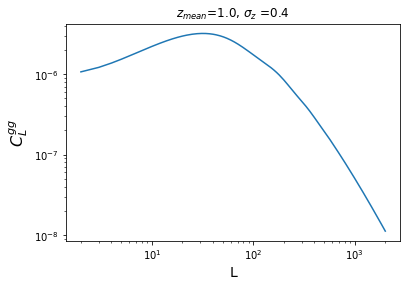

In [15]:
plt.figure()
if LSST:
    plt.title('LSST bin=%s'%(str(bin_num)),fontsize=12)
else:
    plt.title('$z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z0, sigma_z),fontsize=12)   
plt.ylabel(r'$C_L^{gg}$', fontsize=16)
plt.xlabel('L', fontsize=14)
p=plt.loglog(ell_,Cl_gg)
plt.loglog(ell_,-Cl_gg,c=p[0].get_color(),ls='--')
plt.savefig(plotpath+'Clgg_%s.pdf'%file_ext, bbox_inches='tight')
plt.show()

### first order Jacobian term

In [16]:
try:
    ell_,J11bare = np.load('../output/cls/ClkgJacobianbare_%s.npy'%(file_ext))
except:
    clphiphi_xi_xi_source = np.load('../G_matrices/clphiphi_parallel_chisource_%s.npy'%file_ext)

    kernel1 = galax_kernel
    result = np.zeros_like(ell_)
    for ii in range(len(ell_)):
        result[ii]= ell_[ii]**4*chimax*np.sum(w1*kernel1(t_*chimax)*clphiphi_xi_xi_source[ii])/2.
    J11bare = result
    np.save('../output/cls/ClkgJacobianbare_%s.npy'%(file_ext),[ell_,J11bare])

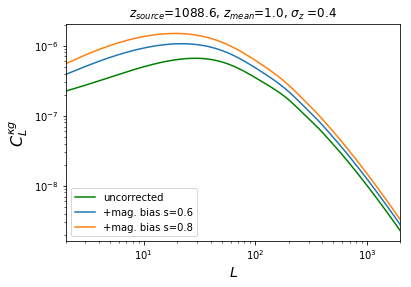

In [19]:
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=12)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=12)   
plt.loglog(ell_,Cl_kg,ls='-',label='uncorrected',color='green')
for s in [0.6,0.8]:
    p=plt.semilogx(ell_,J11bare*5.*(s-0.4)+Cl_kg,ls='-', label='+mag. bias s=%.1f'%s)
    plt.semilogx(ell_,-(J11bare*5.*(s-0.4)+Cl_kg),ls='--', c=p[0].get_color())
plt.xlabel('$L$',fontsize=14)
plt.ylabel(r'$C_L^{\kappa g}$', fontsize=16)
plt.legend()
plt.xlim(min(ell_),max(ell_))
plt.savefig(plotpath+'clkg_magbias_%s.pdf'%file_ext, bbox_inches='tight')


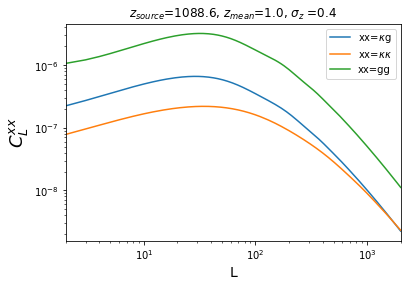

In [18]:
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=12)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=12)   
plt.loglog(ell_,Cl_kg,label='xx=$\kappa$g')
plt.loglog(ell_,Cl_kk,label='xx=$\kappa\kappa$')
plt.loglog(ell_,Cl_gg,label='xx=gg')
plt.legend(fontsize=14)
plt.xlabel('L',fontsize=14)
plt.ylabel(r'$C_L^{xx}$', fontsize=18)
plt.legend()
plt.xlim(min(ell_),max(ell_))
plt.savefig(plotpath+'cls_%s.pdf'%file_ext, bbox_inches='tight')


### 1) Terms that also appear in Limber approximation

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$- \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_l^{\delta\psi}(\chi',\chi) C_{|\vec{L}-\vec{l}|}^{\phi\phi}(\chi',\chi) = - \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 M^{A}(l,|\vec{L}-\vec{l}|)$
after  transform $\vec{l} \rightarrow \vec{l}+\vec{L}$

$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 M^{A}( |\vec{L}+\vec{l}|,l)$

Term 2: 
$ L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_L^{\delta\psi}(\chi',\chi) [\frac{1}{2}C_{l}^{\phi\phi}(\chi')+\frac{1}{2}C_{l}^{\phi\phi}(\chi)]$
$ = L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \tilde{M}^{A}(L,l)$

Comparison with Limber results suggest that we are missing a minus sign in Term 2. Will be coding with this Minus sign

Adding Term 1 and 2 with trick from Krause & Hirata:
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$


### Coding the new equation for Term 1:
$\frac{\mathcal A}{2 \pi^2} \sum_n \int dr \chi_{cmb}^{-\nu} r^{-\nu-1} W(r \chi_{cmb},\chi_{cmb}) [1+z(r \chi_{cmb})] D(r \chi_{cmb})\int dt I^{(2)}(\nu_n, t)[ D(tr  \chi_{cmb})W_h(tr  \chi_{cmb}) C_{l1}^{\phi\phi}(tr  \chi_{cmb},r \chi_{cmb})+ t^\nu D(r/t  \chi_{cmb})W_h(r/t  \chi_{cmb}) C_{l1}^{\phi\phi}(r/t  \chi_{cmb},r \chi_{cmb}))]$

In [20]:
#getting MA Eq. 4.4
chi1s, chi2s, clphiphirt = np.load('../G_matrices/clphiphi_rt_%s.npy'%file_ext2)
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t_%s.npy'%file_ext2)
clphiphirt = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t = np.swapaxes(clphiphir_over_t,1,2)

try: 
    _, M22A = np.load('../M_matrices/M22A_%s.npy'%file_ext)
    M22A_spline = RectBivariateSpline(ell_,ell_,M22A)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_ = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M22A = chimax * result*1./np.pi**2/2.*prefac/4.
    np.save('../M_matrices/M22A_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22A.T])

    M22A_spline = RectBivariateSpline(ell_,ell_,M22A.T)

### clphiphi diag for term 2

In [21]:
#getting tilde MA Eq.4.3

# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel_%s.npy'%file_ext2)

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chimax*t_,cl_phiphi_diag[ii])]
#transpose of code
try:
    _, M31aA = np.load('../M_matrices/M31aA_%s.npy'%file_ext)
    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (galax_kernel(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax)))
        chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*(1.+z_chi(r2d/t2d*chimax)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M31aA = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M31aA_%s.npy'%file_ext,[np.meshgrid(ell_),M31aA.T])

    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA.T)
    M31aA = M31aA.T

In [22]:
#getting tilde MA2 (Eq.4.5)
try:
    _, M13a = np.load('../M_matrices/M13a_%s.npy'%file_ext)
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M13a = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M13a_%s.npy'%file_ext,[np.meshgrid(ell_),M13a.T])
    
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a.T)
    M13a = M13a.T

In [23]:
#adding M13A and M31Aa
tildeMA        = M13a+M31aA
tildeMA_spline = RectBivariateSpline(ell_,ell_,tildeMA)

In [24]:
# sampling for integrations
#31 term only
def get_31_term_only(L,L1,M):
    return -L**4/np.pi*simps(M(L,L1)*L1**3,L1)/4.

In [25]:
phi       = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1        = np.logspace(np.log(2),3,400)
term31    = get_31_term_only(L1=l,L=L, M=tildeMA_spline)

## Now that we have $M^A$ s: coding this equations
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$

In [26]:
def get_regularized_sum_of_terms(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand = LL1*(LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*((LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [27]:
# use same sampling as in Limber case

# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

In [28]:
MA_spline       = M22A_spline
tildeMA_spline  = tildeMA_spline
try:
    L,term1 = np.load('../output/results/term1_%s.npy'%file_ext)
except:
    begin = time.time()
    term1 = get_regularized_sum_of_terms(L,l,phi,MA_spline,tildeMA_spline,method='trapz')+get_second_sum_of_terms(L,l,phi,tildeMA_spline,method='trapz')
    print(time.time()-begin)

    np.save('../output/results/term1_%s'%file_ext,[L,term1])

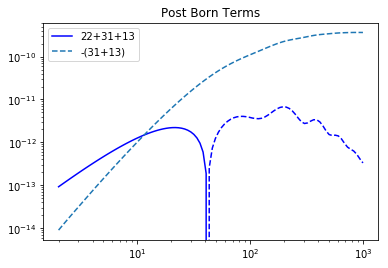

In [30]:
plt.figure()
plt.title('Post Born Terms')
plt.loglog(L,term1,label='22+31+13',color='b')
plt.loglog(L,-term1,color='b',ls='--')
plt.plot(L,-term31, ls='--' ,label='-(31+13)')
plt.legend()

# additional terms that are zero in Limber

## Eq. 4.2

In [31]:
# clphipsi code
try:
    Cl = np.load('../G_matrices/clphipsi_%s.npy'%file_ext)
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)
    chi2_max = chimax
    chi1_max = chimax

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    # inflate by one dimensions (nu_n)
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chi1_max in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        #psi goes with chi2
        chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
        chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

        # no lensing kernel, because no lensing integration of chi_2
        chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*inner_kernel(r2d*t2d*chi2_max, chi1_max))

        chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*inner_kernel(r2d*1./t2d*chi2_max, chi1_max))

        chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w12*chi1fac0* chi2fac0

        result = np.zeros((len(ell_),len(t_)))
        lmax   = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

        #jj is chi1 -> phi
        Cl[jj] = result*1./np.pi**2/2.*prefac**2 #divide by two for Gauss quad and times two for phi cancel
    # swap axes to have cl_phipsi_l(chi_max,chi)
    Cl = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)

    # first axis ell, second phi, third psi
    np.save('../G_matrices/clphipsi_%s'%file_ext,Cl)
    
clphipsi = np.swapaxes(Cl,1,2)

In [32]:
# clphidelta
try:
    cldeltaphi = np.load('../G_matrices/clphidelta_%s.npy'%file_ext)
except:
    
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    chimax2   = chimax

    n = 2

    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chimax1 in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        chi1fac0  = D_chi(r2d*chimax2)
        chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))

        chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*inner_kernel(r2d*t2d*chi2_max, chimax1))

        chi2fac01 = (inner_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w12*chi1fac0* chi2fac0

        result    = np.zeros((len(ell_),len(t_)))
        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

        Cl[jj] = result*1./np.pi**2/2.*prefac/2.*2

    cldeltaphi = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)


    # first axis ell, second phi, third delta
    np.save('../G_matrices/clphidelta_%s'%file_ext,cldeltaphi)

In [33]:
try:
    _ ,M22B = np.load('../M_matrices/M22B_%s.npy'%str(file_ext))
except:
    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*chimax**2*kernel1(r2d*chimax)*kernel2(t2d*chimax)*cldeltaphi[ii]*clphipsi[jj])/4.

    M22B = result

    # first index is L-l, second index is l
    np.save('../M_matrices/M22B_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22B])

M22B_spline = RectBivariateSpline(ell_,ell_,M22B)

In [34]:
#this is the term which seems to be absent in the auto
clphipsi_diag = np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag[:,ii]=clphipsi[:,ii,ii]

clphipsi_diag_blown=np.zeros((len(ell_),len(t_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag_blown[:,ii]=clphipsi_diag

try:
    _ , M31aB = np.load('../M_matrices/M31aB_%s.npy'%file_ext)
except:
    cldeltaphi=cldeltaphi.swapaxes(1,2)

    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chimax)*kernel2(r2d*chimax)*clphipsi_diag_blown[jj]*cldeltaphi[ii])
    result*=chimax**2/4.

    M31aB = result

    # first index is L
    np.save('../M_matrices/M31aB_%s.npy'%file_ext,[np.meshgrid(ell_),M31aB])

M31aB_spline = RectBivariateSpline(ell_,ell_,M31aB)

In [35]:
def get_regularized_sum_of_terms_2(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = -LL*LL1*nu*(LL*LL1*nu-LL1**2)**2*LL1*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms_2(L,L1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*(((LL*LL1*nu)**2*LL1**2)-LL*LL1*nu*(LL*LL1*nu-LL1**2)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


In [36]:
try:
    L, term2 = np.load('../output/results/term2_%s.npy'%file_ext)
except:    
    term2 = get_regularized_sum_of_terms_2(L,l,phi,M22B_spline,M31aB_spline,method='trapz')+get_second_sum_of_terms_2(L,l,M31aB_spline,method='trapz')
    np.save('../output/results/term2_%s'%file_ext,[L,term2])

### 1) Non-Limber Terms Equations 4.6-4.7, these are the the 13b and 31b terms, out of which one should be much smaller for different redshifts

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{\delta\phi}(\chi',\chi'')\\
= 2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi W(\chi,\chi_{CMB}) \int_0^\chi \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{g\phi}(\chi'') $




In [37]:
chimaxs = np.load('../G_matrices/clphigalchimaxs_%s.npy'%file_ext)
clgphi  = np.load('../G_matrices/clphigal_%s.npy'%file_ext)
#check if chimaxs are in correct order

r2d, t2d = np.meshgrid(t_,t_)
np.prod((chimaxs==r2d*t2d*chimax))

try:
    _, M31b = np.load('../M_matrices/M31b_%s.npy'%str(file_ext))
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)
    
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clgphi_  = np.expand_dims(clgphi,-1)


    result   = np.zeros((len(ell_),len(ell_)))

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = inner_kernel(r2d*t2d*chimax,chimax*r2d)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax))*clgphi_[nn]

        chi2fac0  = chi2fac00

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I0_ltrc[ii])

    print(time.time()-begin)

    #- sign from going clphidelta
    M31b = -chimax*result*1./np.pi**2/2.*prefac**2/4.*2

    #first index L, second index l
    np.save('../M_matrices/M31b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M31b])
M31b_spline = RectBivariateSpline(ell_,ell_,M31b)
# to do: check if l grids are correct

In [38]:
# Eq. 5.6
def l_integration_1(M,L,l):
    return L**2*np.trapz(l**5*M(L,l),l)/4./np.pi


In [39]:
res=[]
for LL in L:
    res+=[l_integration_1(M31b_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term3_%s.npy'%file_ext,[L,res])
term31b = res


Term 2:
$-2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\psi}(\chi'',\chi)   C_l^{\delta\phi}(\chi',\chi'')\\
= -2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi'  W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\phi}(\chi'')   C_l^{\delta_h \phi}(\chi',\chi'') $

In [40]:
#phi goes up to chi''
clphidelta  = np.load('../G_matrices/clphidelta_parallel_MB2_%s.npy'%file_ext2)


#phi goes to chi_source
clphipsi    = np.load('../G_matrices/clpsiphi_parallel_MB2_%s.npy'%file_ext2)

print(clphidelta.shape)
print(clphipsi.shape)

try:
    _, M13b = np.load('../M_matrices/M13b_%s.npy'%str(file_ext))
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)

    kernel2 = inner_kernel
    kernel1 = galax_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)


    result   = np.zeros((len(ell_),len(ell_)))

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = kernel1(r2d*chimax)
        chi1fac0 = chi1fac0*(r2d*chimax)

        chi2fac0 = r2d*kernel2(r2d*t2d*chimax,chimax*r2d)*clphipsi[nn]
        chifacs  = w11*w12*chi1fac0*chi2fac0

        for ii  in range(len(ell_)):        
            result[nn][ii] = np.sum(chifacs*clphidelta[ii])

    #first index is L
    M13b = chimax**2*result/4. #chimax or chimax**2 ?

    np.save('../M_matrices/M13b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M13b])
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)

(289, 100, 100)
(289, 100, 100)


In [41]:
#all minus signs cancel
def l_integration_2(M,L,l):
    return L**4*np.trapz(l**3*M(L,l),l)/4./np.pi #2 went into clphipsi

In [42]:
res=[]
for LL in L:
    res+=[l_integration_2(M13b_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term4_%s.npy'%file_ext,[L,res])
term13b = res

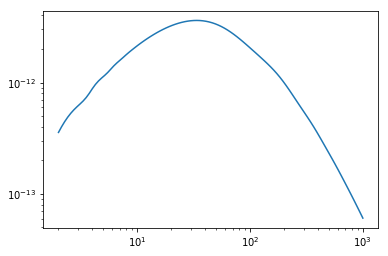

In [43]:
plt.loglog(L,res)

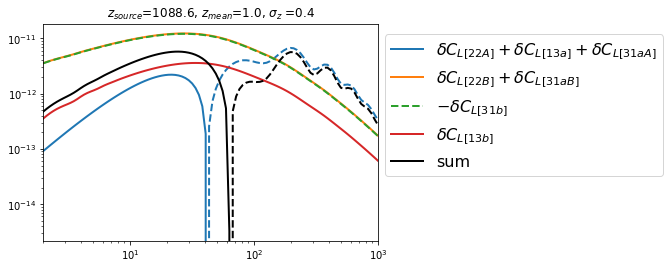

In [59]:
plt.figure()
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=12)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=12)  
#plt.title('Post Born terms (without Jacobian)',fontsize=14)
p=plt.loglog(L,term1,label='$\delta C_{L[22A]}+\delta C_{L[13a]}+\delta C_{L[31aA]}$',lw=2)
plt.loglog(L,-term1,ls='--',c=p[0].get_color(),lw=2)
plt.loglog(L,term2,label='$\delta C_{L[22B]}+\delta C_{L[31aB]}$',lw=2)
plt.loglog(L,-term31b,label='$-\delta C_{L[31b]}$',ls='--',lw=2)
plt.loglog(L,term13b,label='$\delta C_{L[13b]}$',ls='-',lw=2)
plt.loglog(L,term1+term2+term31b+term13b,ls='-',c='k',lw=2,label='sum')
plt.loglog(L,-(term1+term2+term31b+term13b),ls='--',c='k',lw=2)
plt.legend(loc=(1.02,0.3),fontsize=16)
plt.xlim(min(L),max(L))
plt.savefig(plotpath+'postbornterms_%s.png'%file_ext, bbox_inches='tight')

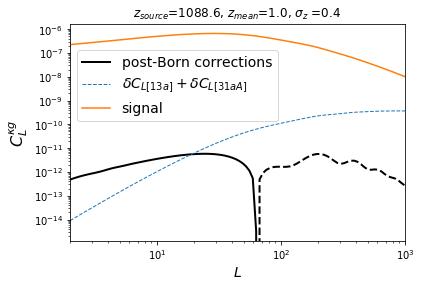

In [58]:
plt.figure()
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=12)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=12)  
plt.loglog(L,term1+term2+term31b+term13b,ls='-',c='k',lw=2,label='post-Born corrections')
plt.loglog(L,-(term1+term2+term31b+term13b),ls='--',c='k',lw=2)
plt.loglog(L,-term31,ls='--',lw=1,label='$\delta C_{L[13a]}+\delta C_{L[31aA]}$')
plt.plot(ell_,Cl_kg,label='signal')
plt.legend(fontsize=14,loc=(0.02,0.55))
plt.xlim(min(L), max(L))
plt.xlabel('$L$',fontsize=14)
plt.ylabel('$C_L^{\kappa g}$',fontsize=16)
plt.savefig(plotpath+'signal_vs_corrections_%s.png'%file_ext, bbox_inches='tight')